In [1]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Optim
using Plots
using Random
using StateSpaceDynamics

In [13]:
# Random.seed!(1234)
g = 9.81
l=1
# time differential
dt = 0.01
# transition matrix
A = Matrix{Float64}([1.0 dt; -g/l*dt 1.0])
# Initial state
x0 = [0.0, 1.0]
# Define the LDS model parameters
C = Matrix{Float64}(I(2))  # Observation matrix (assuming direct observation)
Q = Matrix{Float64}(0.01 * I(2))  # Process noise covariance
observation_noise_std = 0.5
R = Matrix{Float64}((observation_noise_std^2) * I(2))  # Observation noise covariance
P0 = Matrix{Float64}(0.1*I(2))  # Initial state covariance

lds = StateSpaceDynamics.GaussianLDS(;A=A, C=C, Q=Q, R=R, x0=x0, P0=P0, obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true])

x, y = StateSpaceDynamics.sample(lds, 300, 1)

([0.31577473659258964 0.4994545366393596 … -1.670000397535882 -1.5858268978182923;;; 1.4144829317757344 1.6032375035168445 … -1.5286467153313343 -1.267982298790795], [0.25098775797473316 0.4748832947690179 … -1.7159388401296876 -0.7947626043520714;;; 1.8309095807562827 2.1107280400025066 … -1.329794238046086 -1.761697274512841])

In [14]:
new_lds = GaussianLDS(obs_dim=2, latent_dim=2)
lls = fit!(new_lds, y; max_iter=100)


true


Fitting LDS via EM...   3%|█                             |  ETA: 0:00:05

true
true
true
true


Fitting LDS via EM...   6%|██                            |  ETA: 0:00:05

true
true


Fitting LDS via EM...   9%|███                           |  ETA: 0:00:05

true
true
true
true


Fitting LDS via EM...  12%|████                          |  ETA: 0:00:05

true
true


Fitting LDS via EM...  15%|█████                         |  ETA: 0:00:05

true
true


Fitting LDS via EM...  18%|██████                        |  ETA: 0:00:04

true
true
true
true
true


Fitting LDS via EM...  21%|███████                       |  ETA: 0:00:04

true
true


Fitting LDS via EM...  24%|████████                      |  ETA: 0:00:04

true
true


Fitting LDS via EM...  27%|█████████                     |  ETA: 0:00:04

true
true
true
true
true
true


Fitting LDS via EM...  30%|██████████                    |  ETA: 0:00:04

true


Fitting LDS via EM...  32%|██████████                    |  ETA: 0:00:04

true
true


Fitting LDS via EM...  34%|███████████                   |  ETA: 0:00:04

true
true
true

Fitting LDS via EM...  37%|████████████                  |  ETA: 0:00:04


true
true
true


Fitting LDS via EM...  40%|█████████████                 |  ETA: 0:00:03

true
true


Fitting LDS via EM...  42%|█████████████                 |  ETA: 0:00:03

true


Fitting LDS via EM...  44%|██████████████                |  ETA: 0:00:03

true
true
true
true
true
true
true


Fitting LDS via EM...  51%|████████████████              |  ETA: 0:00:03

true
true
true
true


Fitting LDS via EM...  54%|█████████████████             |  ETA: 0:00:03

true
true
true


Fitting LDS via EM...  57%|██████████████████            |  ETA: 0:00:02

true
true
true


Fitting LDS via EM...  60%|███████████████████           |  ETA: 0:00:02

true
true
true
true


Fitting LDS via EM...  63%|███████████████████           |  ETA: 0:00:02

true
true


Fitting LDS via EM...  67%|█████████████████████         |  ETA: 0:00:02

true
true
true
true
true
true
true


Fitting LDS via EM...  73%|██████████████████████        |  ETA: 0:00:01

true
true
true
true


Fitting LDS via EM...  77%|████████████████████████      |  ETA: 0:00:01

true
true
true


Fitting LDS via EM...  80%|█████████████████████████     |  ETA: 0:00:01

true
true
true


Fitting LDS via EM...  83%|█████████████████████████     |  ETA: 0:00:01

true
true


Fitting LDS via EM...  86%|██████████████████████████    |  ETA: 0:00:01

true
true
true


Fitting LDS via EM...  89%|███████████████████████████   |  ETA: 0:00:01

true
true
true
true
true


Fitting LDS via EM...  92%|████████████████████████████  |  ETA: 0:00:00

true
true


Fitting LDS via EM...  95%|█████████████████████████████ |  ETA: 0:00:00

true
true


Fitting LDS via EM...  97%|██████████████████████████████|  ETA: 0:00:00

true


Fitting LDS via EM...  99%|██████████████████████████████|  ETA: 0:00:00

true
true


Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:05


true


100-element Vector{Float64}:
 -2347.1896627643637
 -1176.2055751637108
  -768.9265292927474
  -351.27882459131513
    -0.6247122354970216
   263.39892800691496
   446.54678249660714
   565.9091869472581
   642.9204360995712
   695.8992605892292
     ⋮
  1375.3854995398974
  1376.828757349753
  1378.246000089245
  1379.637938409238
  1381.005252697424
  1382.3485948341681
  1383.6685898282371
  1384.9658373412149
  1386.2409131088436

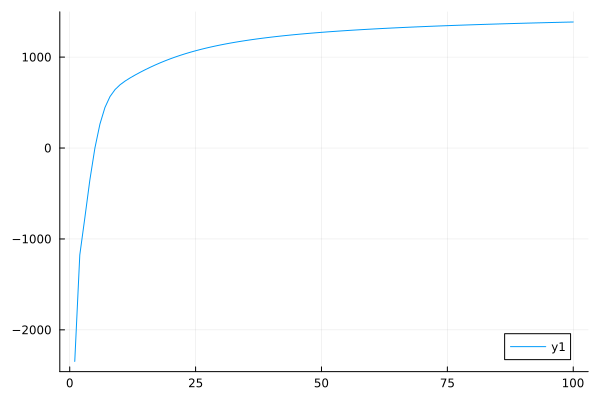

In [15]:
plot(lls)

In [21]:
mls = []
qs =[]
entropies = []
for i in 1:100
    A, Q, x0, p0, C, R = lds.state_model.A, lds.state_model.Q, lds.state_model.x0, lds.state_model.P0, lds.obs_model.C, lds.obs_model.R
    E_z, E_zz, E_zz_prev, x_smooth, P_smooth, ml = StateSpaceDynamics.estep(lds, y)

    n_trials = size(E_z, 1)
    # calculate q
    ecll = 0.0
    for trial in 1:n_trials
        ecll += Q_val = StateSpaceDynamics.Q_function(
            A,
            Q,
            C,
            R,
            P0,
            x0,
            E_z[trial, :, :],
            E_zz[trial, :, :, :],
            E_zz_prev[trial, :, :, :],
            y[trial, :, :],
        )
    end
       
    entropy = 0.0
    for trial in 1:size(E_z, 1)
        for tStep in 1:size(E_z, 2)
            cov_matrix = P_smooth[trial, tStep, :, :] # Extract covariance matrix
            entropy += StateSpaceDynamics.gaussianentropy(cov_matrix)
        end
    end
    push!(mls, ml)
    push!(qs, ecll)
    push!(entropies, entropy)
    StateSpaceDynamics.mstep!(lds, E_z, E_zz, E_zz_prev, P_smooth, y)
end


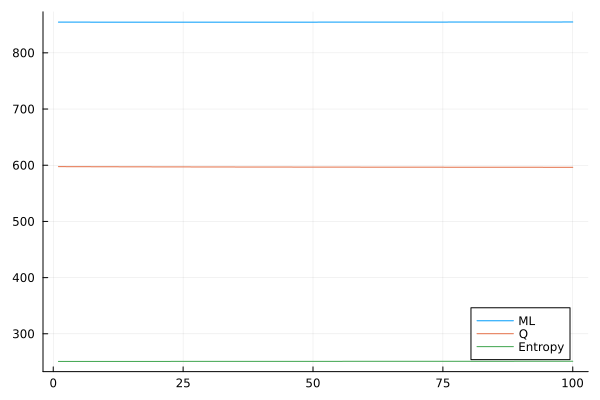

In [23]:
plot(mls, label="ML")
plot!(qs, label="Q")
plot!(-entropies, label="Entropy")

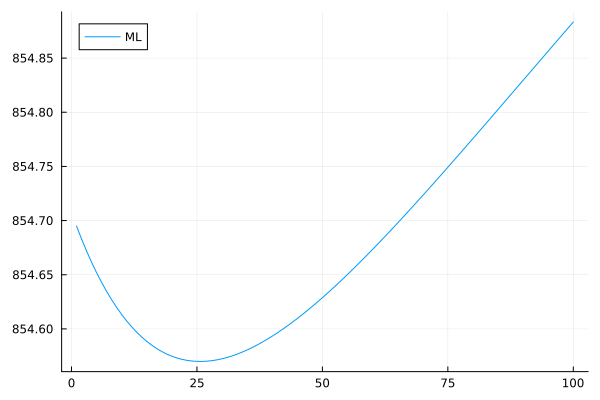

In [24]:
plot(mls, label="ML")

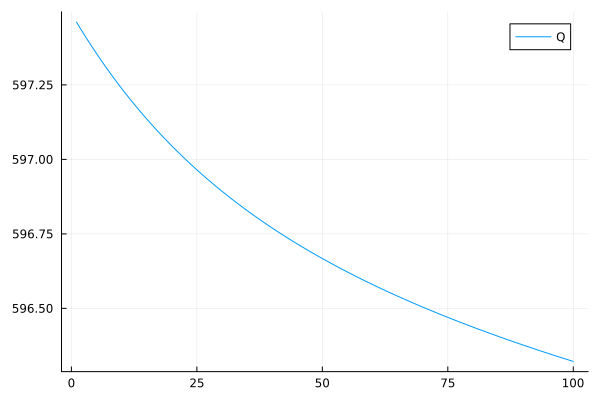

In [25]:
plot(qs, label="Q")

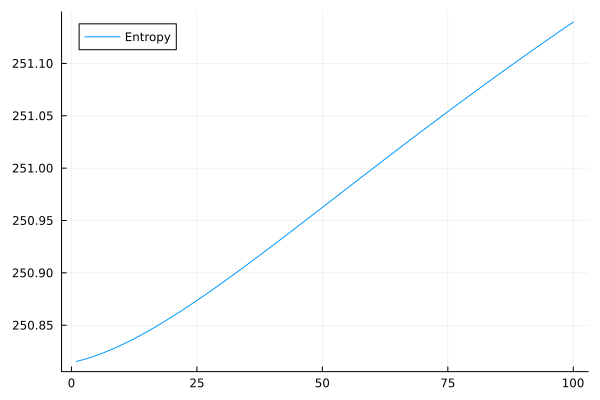

In [27]:
plot(-entropies, label="Entropy")

In [5]:
ls = fit!(lds, y, max_iter=1000)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:01:11


1000-element Vector{Float64}:
 290.20174487222965
 296.9559258591217
 299.02556402625214
 300.50816123707625
 301.653859960237
 302.61205031926136
 303.46631752398997
 304.26387970281894
 305.03202377850056
 305.7867744999036
   ⋮
 671.5493874844781
 671.632098127873
 671.7146940182379
 671.7971754530342
 671.8795427287473
 671.9617961402082
 672.0439359818754
 672.1259625464636
 672.20787612564

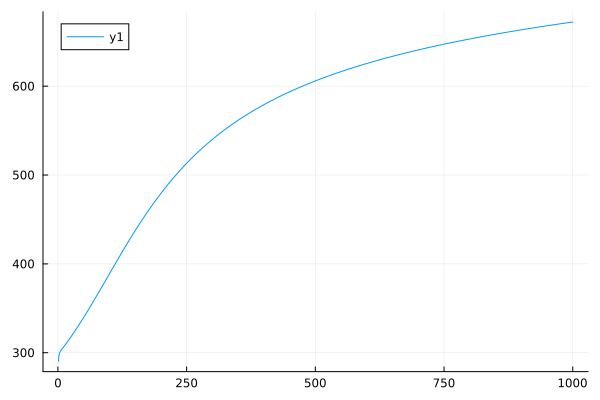

In [6]:
plot(ls)

In [18]:
all(diff(ls) .> 0)

false

In [92]:
E_z, E_zz, E_zz_prev, x_smooth, p_smooth, ml_total = SSM.estep(lds, y)

([-0.12707975276822361 -0.11729631582924951 … 0.3465653283138277 0.3386174371376877; 0.14454061101087512 0.21357414661475493 … -0.214415997348437 -0.277336393973309; -0.0477774007375271 -0.04908940404027147 … 1.037314341857955 1.0070498171224052;;; 1.311320757944344 1.3392750662499917 … -0.2581278105895398 -0.28096269403659824; 1.4295785540411698 1.4565996562607397 … -5.023868220692389 -5.003124717012324; 0.9049928716262414 0.8662675174547664 … -0.40190648580485505 -0.49191799775156564], [0.046123523320992815 0.04154556194451241 … 0.15747186439415659 0.1587348730281291; 0.05086624798875709 0.07340105233961819 … 0.08333855752381035 0.12098857971655166; 0.032256939778594236 0.030196905826426382 … 1.1133853814290875 1.0582224384607029;;; -0.16230598461934587 -0.15411734669068522 … -0.09440326703692621 -0.10272232961625824; 0.210968490789215 0.3140667130076457 … 1.0722525974738433 1.379965105384645; -0.03890187399223141 -0.039549871708887095 … -0.4218484794241395 -0.5029693919052189;;;; -0

In [61]:
x0_new = (E_z[1, 1, :] + E_z[2, 1, :] + E_z[3, 1, :]) ./ 3

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [87]:
function obj(x0::AbstractVector, P0_sqrt::AbstractMatrix, lds)
    A, Q = lds.state_model.A, lds.state_model.Q
    P0 = P0_sqrt * P0_sqrt'
    Q_val = 0.0
    for i in axes(E_z, 1)
        Q_val += SSM.Q_state(A, Q, P0, x0, E_z[i, :, :], E_zz[1, :, :, :], E_zz_prev[1, :, :, :])
    end
    return -Q_val
end

p0_init = Matrix(cholesky((p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3).U) .+ 1e-6

result = optimize(p0_sqrt -> obj(x0_new, p0_sqrt, lds), p0_init, LBFGS(), Optim.Options(g_tol=1e-12))

DomainError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [94]:
fit!(lds, y, max_iter=1)

1-element Vector{Float64}:
 634.1856079992872

In [101]:
# optimize the A and Q entries using autograd
function obj(A::AbstractMatrix, Q_sqrt::AbstractMatrix, lds)
    Q = Q_sqrt * Q_sqrt'
    Q_val = 0.0
    for i in axes(E_z, 1)
        Q_val += SSM.Q_state(A, Q, lds.state_model.P0, lds.state_model.x0, E_z[i, :, :], E_zz[1, :, :, :], E_zz_prev[1, :, :, :])
    end
    return -Q_val
end

Q_sqrt = rand(2, 2)
result_a = optimize(A_new -> obj(A_new, Q_sqrt, lds), A, LBFGS(), Optim.Options(g_tol=1e-12))

f = A_new -> obj(A_new, Q_sqrt, lds)
ForwardDiff.gradient(f, lds.state_model.A)

2×2 Matrix{Float64}:
  2.15768   -3.15425
 -4.12196  -12.4146

In [103]:
result_a.minimizer

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [104]:
lds.state_model.A

2×2 Matrix{Float64}:
  0.993706  0.00769286
 -0.100821  1.00272

In [66]:
result.minimizer * result.minimizer'

2×2 Matrix{Float64}:
  0.294608  -1.37822
 -1.37822    6.44752

In [110]:
S01_1 = dropdims(sum(E_zz_prev[1, :, :, :], dims=1), dims=1)
S01_2 = dropdims(sum(E_zz_prev[2, :, :, :], dims=1), dims=1)
S01_3 = dropdims(sum(E_zz_prev[3, :, :, :], dims=1), dims=1)

S00_1 = dropdims(sum(E_zz[1, 1:end-1, :, :], dims=1), dims=1)
S00_2 = dropdims(sum(E_zz[2, 1:end-1, :, :], dims=1), dims=1)
S00_3 = dropdims(sum(E_zz[3, 1:end-1, :, :], dims=1), dims=1)

A_1 = S01_1 / S00_1
A_2 = S01_2 / S00_2
A_3 = S01_3 / S00_3

A_new = (A_1 + A_2 + A_3) ./ 3

2×2 Matrix{Float64}:
  0.979349  0.0167926
 -0.102614  1.00222

In [113]:
(S01_1 + S01_2 + S01_3) / (S00_1 + S00_2 + S00_3)

2×2 Matrix{Float64}:
  0.993706  0.00769286
 -0.100821  1.00272

In [112]:
ForwardDiff.gradient(f, A_new)

2×2 Matrix{Float64}:
  1.96989   -0.801541
 -4.9502   -14.7797

In [89]:
(p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3

2×2 Matrix{Float64}:
 0.0299743   0.00433633
 0.00433633  0.0323025

In [88]:
((E_zz[1, 1, :, :] - (x0_new * x0_new')) + (E_zz[2, 1, :, :] - (x0_new * x0_new')) + (E_zz[3, 1, :, :] - (x0_new * x0_new'))) ./ 3

2×2 Matrix{Float64}:
 0.0429801  0.0155347
 0.0155347  0.0827777

In [74]:
Matrix(cholesky((p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3).U)

Cholesky{Float64, Matrix{Float64}}
U factor:
2×2 UpperTriangular{Float64, Matrix{Float64}}:
 0.173131  0.0250466
  ⋅        0.177975

In [72]:
fit!(lds, y, max_iter=1)

1-element Vector{Float64}:
 634.1856079992872

In [73]:
lds.state_model.P0

2×2 Matrix{Float64}:
 0.0429801  0.0155347
 0.0155347  0.0827777

In [21]:
lds_old = LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)
KalmanFilterEM!(lds_old, y[1, :, :], 1)

lds_old.A

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [22]:
lds_old.R

2×2 Matrix{Float64}:
 0.30225    0.0106356
 0.0106356  0.224827

In [23]:
fit!(lds, y, max_iter=1, tol=1e-6)
lds.state_model.A

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [24]:
lds.obs_model.R

2×2 Matrix{Float64}:
 0.30225    0.0106356
 0.0106356  0.224827

In [16]:
dropdims(sum(E_zz_prev[1, :, :, :], dims=1), dims=1) / dropdims(sum(E_zz[1, 1:end-1, :, :], dims=1), dims=1)

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

2×2 Matrix{Float64}:
 19.0395   23.3599
 23.3599  101.999

In [13]:
lds.state_model.x0

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [11]:
(x_smooth[1, 1, :] + x_smooth[2, 1, :] + x_smooth[3, 1, :]) ./ 3

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [87]:
mean([x_smooth[1, 1, :], x_smooth[2, 1, :], x_smooth[3, 1, :]])

2-element Vector{Float64}:
 -0.010105514164958584
  1.2152973945372534

In [33]:
lls = fit!(lds, y, max_iter=200, tol=1e-3)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:02


200-element Vector{Float64}:
 314.4993447458949
 315.1001767805533
 315.69908092830997
 316.29604835391433
 316.89107065239676
 317.4841398417627
 318.0752483556431
 318.66438903596463
 319.2515551256347
 319.8367402612281
   ⋮
 396.13059095037454
 396.4182983252392
 396.7049687780559
 396.990607843033
 397.27522102421
 397.5588137956746
 397.8413916014705
 398.1229598557544
 398.4035239427527

In [37]:
all(diff(lls) .> 0)

true

In [16]:
# write each y to a csv file
using CSV
using DataFrames

for i in 1:3
    CSV.write("/home/ryansenne/Desktop/data$i.csv", DataFrame(y[i, :, :], :auto))
end

In [15]:
y[1, :, :]

100×2 Matrix{Float64}:
 -0.323551    1.70326
  0.969088    1.44884
 -0.498399    1.78164
 -0.331751    1.01118
 -0.0652428   0.850834
 -1.03334     1.5051
 -0.315437    0.772258
 -0.167026    1.82909
  0.438854    1.52128
 -0.777171    1.10948
  ⋮          
  0.956269   -0.774274
  1.31636    -0.506619
  0.204983    0.285933
  0.374959   -0.613604
  0.422337    0.083254
  0.527896   -0.225842
  0.277655   -0.400379
 -0.0398075   0.0640761
  0.204452   -0.00188331

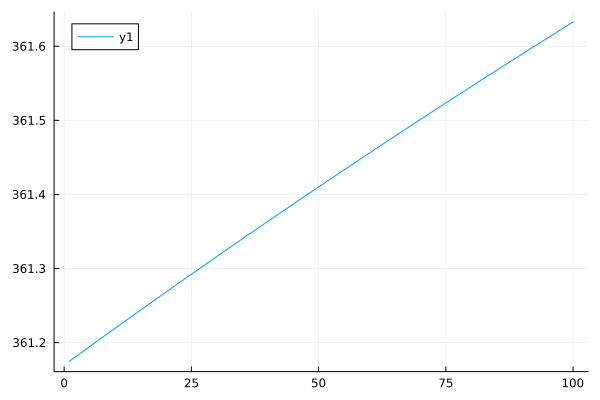

In [38]:
plot(lls)

In [18]:
lds.state_model.Q

2×2 Matrix{Float64}:
 0.0100715   0.00704897
 0.00704897  0.00493425

In [79]:
# test out the LDS model
lds_old = SSM.LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)

# KalmanFilterEM!(lds_old, y[1, :, :], 1, 1e-3, RTSSmoothing())

LDS([1.0 0.01; -0.0981 1.0], [1.0 0.0; 0.0 1.0], [0.0; 0.0;;], [0.01 0.0; 0.0 0.01], [0.25 0.0; 0.0 0.25], [0.0, 1.0], [0.1 0.0; 0.0 0.1], [0.0;;], 2, 2, Bool[1, 1, 1, 1, 1, 1, 1])

In [78]:
lds_old.x0

2-element Vector{Float64}:
 -0.1270797527682236
  1.311320757944344

In [82]:
x, p_smooth, inverse_offdiag = SSM.DirectSmoother(lds_old, y[3, :, :])

([-0.04777740073752734 0.9049928716262423; -0.049089404040271734 0.8662675174547677; … ; 1.0373143418579578 -0.4019064858048561; 1.0070498171224078 -0.49191799775156697], [0.02997425975735998 0.004336333100060944; 0.02778713623739736 0.00297468446241285; … ; 0.03736433760488541 -0.004945117613032814; 0.0440731042944332 -0.007583462230285051;;; 0.004336333100060944 0.03230247103856569; 0.00297468446241285 0.02988592579621252; … ; -0.004945117613032814 0.040343522341738; -0.007583462230285051 0.04814472469529661], [0.0 0.0; 0.02427920404227143 0.0020603290423333565; … ; 0.03035141007521449 -0.005801219493208781; 0.03587969848918758 -0.008279383780838527;;; 0.0 0.0; 0.00472901824481268 0.02639872610250525; … ; -0.0024822724610134507 0.03295674904757299; -0.004367002297707153 0.039258306134208186], 744.851164086406)